In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=2)

## 1d Gaussian

In [2]:
mu = 1
sigma = .3
n=100
samples = mu + sigma*np.random.randn(n)

def likelihood(samples, mu=mu, sigma=sigma):
    return np.exp( - (samples-mu)**2 / sigma**2 / 2) / np.sqrt(2*np.pi) / sigma

In [3]:
class Gauss1D(nn.Module):
    
    def __init__(self, mu=0, z=0):
        super().__init__()
        #parametrize the precision as exponential z
        self.mu= nn.Parameter(torch.tensor(mu, dtype=torch.float))
        self.z = nn.Parameter(torch.tensor(z, dtype=torch.float)) # torch.tensor(2.) #
        
    def forward(self, samples):
        # negative log likelihood of samples
        return .5 *((samples - self.mu)**2 * torch.exp(self.z) - self.z)
    
    def likelihood(self, npsamples):
        return np.exp(-model(torch.from_numpy(npsamples)).detach().numpy())/  np.sqrt(2*np.pi)

In [4]:
model = Gauss1D()
model(torch.from_numpy(samples))

tensor([0.4044, 0.8746, 0.5338, 0.3906, 0.6329, 0.4168, 0.1084, 0.3397, 1.2335,
        0.2129, 0.2640, 0.4070, 0.7154, 0.7192, 0.1251, 0.1816, 0.3671, 0.2582,
        0.3320, 0.4988, 0.6267, 0.8307, 0.4483, 0.1413, 0.3846, 0.4365, 0.7621,
        0.6995, 0.3659, 0.4623, 1.1744, 0.2085, 0.4366, 0.8505, 0.5805, 0.3990,
        0.5152, 0.4253, 0.3134, 0.2094, 0.2190, 0.5614, 0.1355, 0.3339, 0.6982,
        0.4190, 0.1084, 0.7674, 0.9646, 0.3118, 0.3134, 0.3241, 0.4897, 0.4081,
        0.2957, 0.5186, 0.8208, 0.3687, 1.6576, 0.3875, 0.1215, 0.2269, 0.3145,
        0.1935, 1.1352, 0.3039, 0.7271, 0.4977, 0.5797, 0.5160, 0.4216, 0.4289,
        0.3039, 0.4215, 0.9977, 0.7893, 0.8180, 0.2550, 0.7243, 0.0735, 0.5152,
        0.2662, 0.2016, 0.4266, 0.4839, 0.5847, 0.4958, 0.3051, 0.5528, 0.0623,
        0.1121, 0.4626, 0.1358, 1.1895, 0.8138, 0.1662, 1.0678, 0.2471, 1.2730,
        0.3179], dtype=torch.float64, grad_fn=<MulBackward0>)

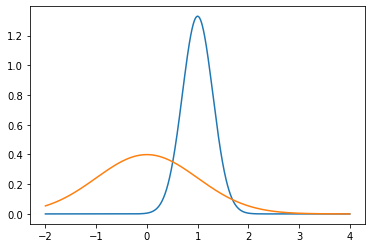

In [5]:
xx = np.linspace(-2, 4, 1000)
plt.plot(xx, likelihood(xx))
plt.plot(xx, model.likelihood(xx))

In [6]:
print(model.likelihood(xx).sum()*6/1000)
print(likelihood(xx).sum()*6/1000)

0.9764030271259628
0.999


0.01


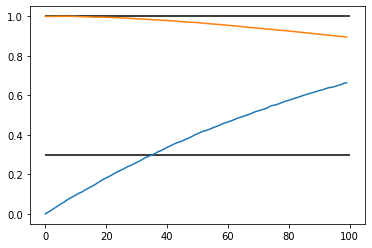

0.05


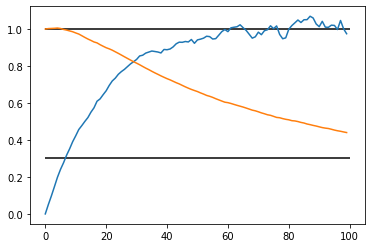

0.1


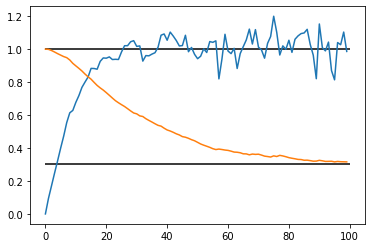

In [7]:
mu = torch.tensor([1.])
sigma = torch.tensor([.3])
n = 10

for lr in [.01,.05,.1]:
    print(lr)
    model = Gauss1D()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
    curves = []
    mus = []
    sigmas = []
    for t in range(100):
        mus += [float(model.mu)]
        sigmas += [float(torch.exp(-model.z/2))] # [float(model.z)]
        curves+=[model.likelihood(xx)]
            
        x = mu + sigma * torch.randn(n)
        
        opt.zero_grad()
        loss = model(x).mean()
        loss.backward()
        opt.step()

    plt.figure()
    plt.plot(mus)
    plt.plot(sigmas)
    plt.hlines([1, .3],0, len(mus))
    plt.show()


In [8]:
print(model.mu)
print(torch.exp(model.z))

Parameter containing:
tensor(1.0283, requires_grad=True)
tensor(10.2662, grad_fn=<ExpBackward>)


# Contour Plot the 2d landscape for different parametrizations
Plot  KL(N(0,1) || N(mu, sigma2)) - and maybe negative log likelihood of the point 0. Is it convex, semi-convex, None ?
* mean parametrization
* natural parametrization
* mean - sqrt param
* natural - sqrt param
* mean - logarithmic param
* natural - logarithmic param

In [11]:
def mean_gauss(mu, var):
    return .5 * ( np.log(var) + (mu**2 + 1 - var)/var )

In [12]:
def std_gauss(mu, std):
    return np.log(std) + (mu**2 + 1)/(2*std**2) - .5 

In [14]:
def natural_gauss(eta, precision):
    return .5 * ( - np.log(precision) + precision - 1 + eta**2 / precision)

In [38]:
def natsqrt_gauss(eta, rho):
    return -np.log(rho) + .5*(rho**2 -1 + (eta/rho)**2)

In [42]:
def meanlog_gauss(mu,z):
    return .5 *(z*np.log(10) + (mu**2 + 1)*10**(-z) -1 )

In [57]:
def natlog_gauss(eta,z):
    precision = 10**z
    return .5 *(-z*np.log(10) +  precision - 1  + eta**2 / precision  )

In [61]:
def contour_gauss(name, func, ymin, ymax):
    xx = np.linspace(0,3,100)
    yy = np.linspace(ymin, ymax,100)
    XX,YY = np.meshgrid(xx,yy)
    plt.figure()
    plt.contour(XX,YY, (func(XX,YY)), levels=np.logspace(-2,1,10))
    if ymin>0:
        plt.ylim(0,ymax)
    plt.colorbar()
    plt.title(name)
    plt.grid()
    plt.show()

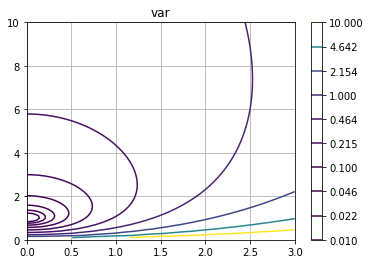

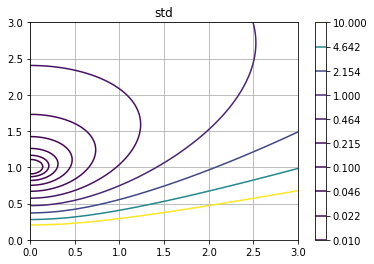

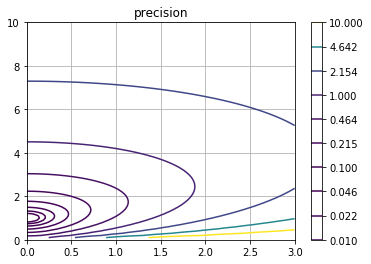

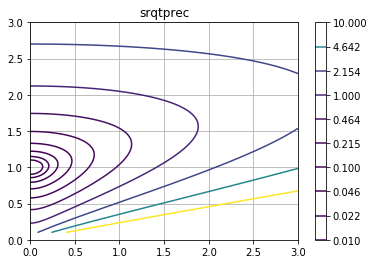

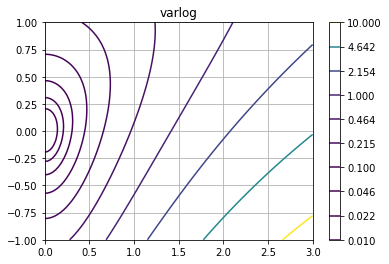

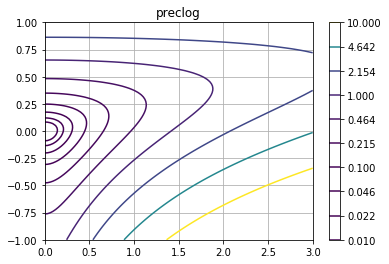

In [63]:
for key,item in {
    'var':(mean_gauss,.1,10),
    'std': (std_gauss, .1, 3),
    'precision':(natural_gaus,.1,10),
    'srqtprec':(natsqrt_gauss,.1,3),
    'varlog':(meanlog_gauss,-1,1),
    'preclog':(natlog_gauss,-1,1)
}.items():
    contour_gauss(key,*item)

Adding exponentials to the picture certainly does not make it better. the landscape is awfully non-convex. It's not even quasiconvex.

Now, I want to  report the minimum eigenvalue of the hessian for each parametrization, to make this idea more precise. I think the best way to do so is to use pytorch autograd. Plus I will learn how to extract a hessian with pytorch. I don't want to derive the formula for each parametrization, and on top of that I will make mistakes.